# Your first CNN on CIFAR-10

笔记：

1. CIFAR-10数据下载到readonly/kears下面
2. `from keras.datasets import cifar10` 用的是 `~/.keras`下面的数据，所以要先link一下。这些就是预处理干的事情。
3. 用GPU跑的运算， 一个epoch大概只需要8s时间， 相比预计的用CPU的时间（4~8min），速度提高至少30倍。跑完15个epoch只需要2min！！！

cifar-10 数据参考： <http://www.cs.toronto.edu/~kriz/cifar.html>

## 0. Import

In [1]:
import sys
sys.path.append("..")

import keras
import keras_utils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import backend as K
%matplotlib inline

/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    return K.get_session()

## 1. 加载、观察，准备数据集

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [4]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

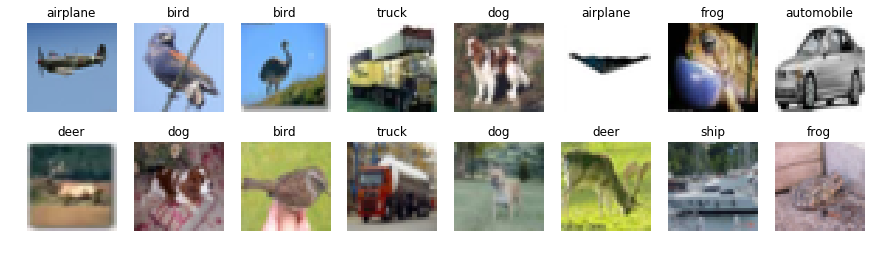

In [5]:
# 随机显示训练数据中的图片
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

分辨率只有 32x32。

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

We need to convert class labels to one-hot encoded vectors. Use __keras.utils.to_categorical__.

In [6]:
# normalize inputs
x_train2 = x_train / 255. - 0.5
x_test2 = x_test / 255. - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)

print(x_train2.shape)
print(y_train2.shape)

(50000, 32, 32, 3)
(50000, 10)


## 2. 设计CNN architecture

In [7]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

You need to define a model which takes __(None, 32, 32, 3)__ input and predicts __(None, 10)__ output with probabilities for all classes. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```

Stack __4__ convolutional layers with kernel size __(3, 3)__ with growing number of filters __(16, 32, 32, 64)__, use "same" padding.

Add __2x2__ pooling layer after every 2 convolutional layers (conv-conv-pool scheme).

Use __LeakyReLU__ activation with recommended parameter __0.1__ for all layers that need it (after convolutional and dense layers):
```python
model.add(LeakyReLU(0.1))
```

Add a dense layer with __256__ neurons and a second dense layer with __10__ neurons for classes. Remember to use __Flatten__ layer before first dense layer to reshape input volume into a flat vector!

Add __Dropout__ after every pooling layer (__0.25__) and between dense layers (__0.5__).

In [8]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    ### YOUR CODE HERE
    # CONV11-ReLU11-CONV12-ReLU12-MAXPOOL1-DROPOUT1
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3)))   # output: (32, 32, 16)
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same'))  # output: (32, 32, 32)
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))                      # output: (16, 16, 32)
    model.add(Dropout(0.25))
    # CONV21-ReLU21-CONV22-ReLU22-MAXPOOL2-DROPOUT2
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same'))  # output: (16, 16, 32)
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))  # output: (16, 16, 64)
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))                      # output: (8, 8, 64)
    model.add(Dropout(0.25))
    # FLATTEN-DENSE1-ReLU-DROPOUT-DENSE2
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation("softmax"))
    
    return model

In [9]:
# describe model
K.clear_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
__________

## 3. Train model

使用Keras训练模型时使用的技巧， callbacks：

1. 使用了一个 learning rate scheduler，按指数衰减。放到 `keras.callbacks.LearningRateScheduler` 里，每训练一个epoch，更新一下
2. `LrHistory`，训练开始时（`on_epoch_begin`）显示learning rate
3. `TqdmProgressCallback` 自定义的进度条显示....
4. `ModelSaveCallback` 自定义的存储Model。

In [10]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 15

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

Training takes approximately **1.5 hours**. You're aiming for ~0.80 validation accuracy.

In [11]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

### uncomment below to continue training from model checkpoint
### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 9
# model = load_model(model_filename.format(last_finished_epoch))

In [12]:
# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
#                keras_utils.TqdmProgressCallback(),
#                keras_utils.ModelSaveCallback(model_filename)
              ],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=1,
    initial_epoch=last_finished_epoch or 0
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
Learning rate: 0.005
50000/50000 [==============================] - 9s 173us/step - loss: 1.3385 - acc: 0.5177 - val_loss: 0.9444 - val_acc: 0.6648
Epoch 2/15
Learning rate: 0.0045
50000/50000 [==============================] - 8s 158us/step - loss: 0.9440 - acc: 0.6677 - val_loss: 0.8637 - val_acc: 0.6936
Epoch 3/15
Learning rate: 0.00405
50000/50000 [==============================] - 8s 158us/step - loss: 0.8117 - acc: 0.7170 - val_loss: 0.7340 - val_acc: 0.7475
Epoch 4/15
Learning rate: 0.003645
50000/50000 [==============================] - 8s 158us/step - loss: 0.7261 - acc: 0.7435 - val_loss: 0.7013 - val_acc: 0.7557
Epoch 5/15
Learning rate: 0.0032805
50000/50000 [==============================] - 8s 158us/step - loss: 0.6614 - acc: 0.7678 - val_loss: 0.6538 - val_acc: 0.7718
Epoch 6/15
Learning rate: 0.00295245
50000/50000 [==============================] - 8s 158us/step - loss: 0.6115 - acc: 0.7862 - val_loss: 0.6421

In [13]:
# save weights to file
model.save_weights("weights.h5")

In [14]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

## 4. Evaluate model

In [15]:
# make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

In [24]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(y_test, y_pred_test_classes))
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

[[834  12  35  10  14   0   7   6  48  34]
 [ 11 891   2   3   1   0   4   0  16  72]
 [ 55   4 715  27  82  29  53  16  12   7]
 [ 14   8  67 620  75 106  71  19  15   5]
 [ 12   1  48  43 825   9  30  23   7   2]
 [  9   4  36 169  47 676  17  34   3   5]
 [  4   1  32  22  26   8 900   2   4   1]
 [ 16   1  35  29  56  28   9 813   3  10]
 [ 42  15   5   6   5   2   6   1 902  16]
 [ 14  31   7   4   3   0   2   5  23 911]]
Test accuracy: 0.8087


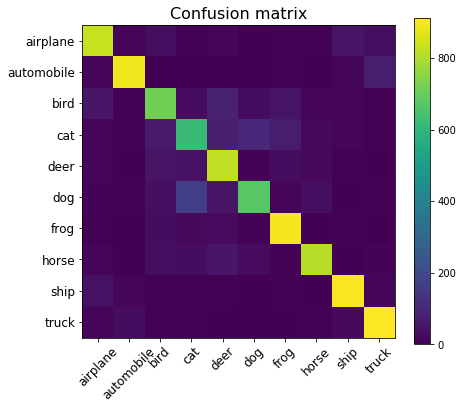

In [25]:
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()

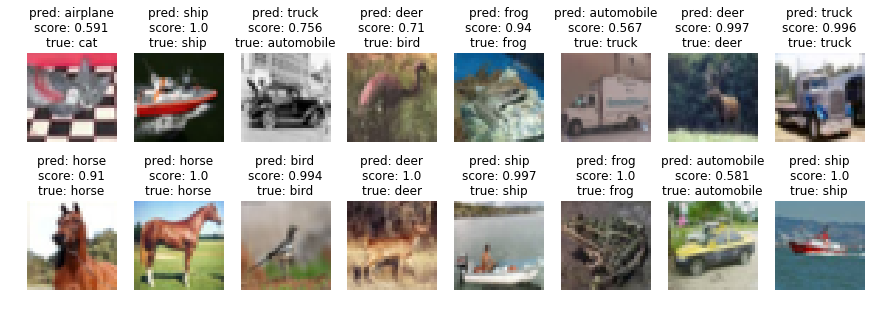

In [26]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Visualize maximum stimuli

We want to find input images that provide maximum activations for particular layers of our network. 

We will find those maximum stimuli via gradient ascent in image space.

For that task we load our model weights, calculate the layer output gradient with respect to image input and shift input image in that direction.

In [52]:
K.clear_session()  # clear default graph
K.set_learning_phase(0)  # disable dropout
model = make_model()
model.load_weights("weights.h5")  # that were saved after model.fit

In [53]:
# all weights we have
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [54]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
    
    def image_values_to_rgb(x):
        # normalize x: center on 0 (np.mean(x_train2)), ensure std is 0.25 (np.std(x_train2))
        # so that it looks like a normalized image input for our network
        x = (x - np.mean(x_train2)) / np.std(x_train2)

        # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
        x = (x + 0.5) * 255
    
        # clip values to [0, 255] and convert to bytes
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    # this is the placeholder for the input image
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    # find the layer output by name
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output

    # we build a loss function that maximizes the activation
    # of the filter_index filter of the layer considered
    if is_conv:
        # mean over feature map values for convolutional layer
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])

    # we compute the gradient of the loss wrt input image
    grads = K.gradients(loss, input_img)[0]  # [0] because of the batch dimension!

    # normalization trick: we normalize the gradient
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    # we run gradient ascent
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    # decode the resulting input image
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value

In [55]:
# sample maximum stimuli
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid(False)
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()

In [60]:
for layer in model.layers:
    print(layer.__class__.__name__, layer.get_input_at(0).__class__.__name__)

Conv2D Tensor
LeakyReLU Tensor
Conv2D Tensor
LeakyReLU Tensor
MaxPooling2D Tensor
Dropout Tensor
Conv2D Tensor
LeakyReLU Tensor
Conv2D Tensor
LeakyReLU Tensor
MaxPooling2D Tensor
Dropout Tensor
Flatten Tensor
Dense Tensor
LeakyReLU Tensor
Dropout Tensor
Dense Tensor
Activation Tensor


conv2d_1


/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


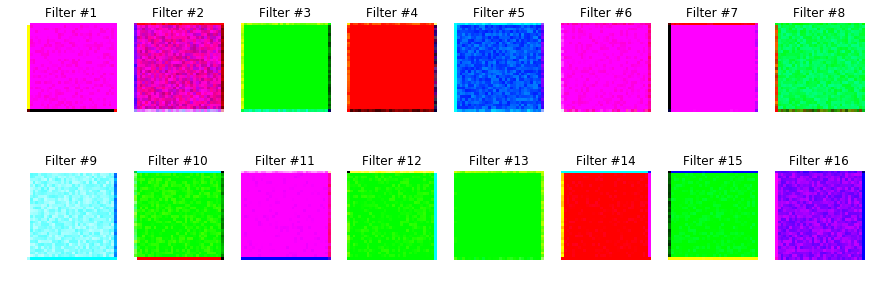

conv2d_2


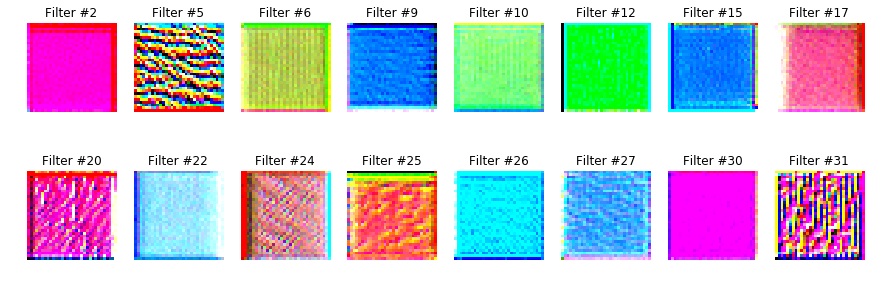

conv2d_3


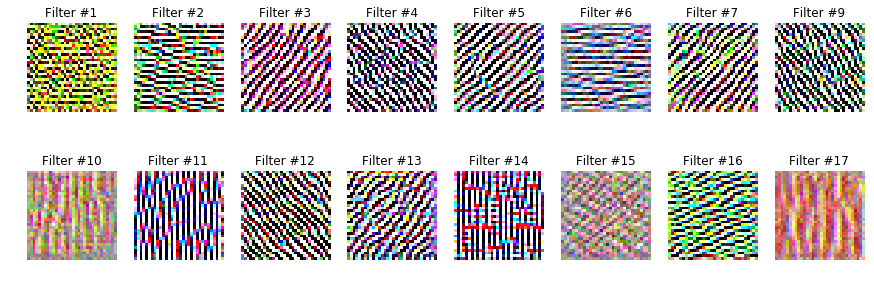

conv2d_4


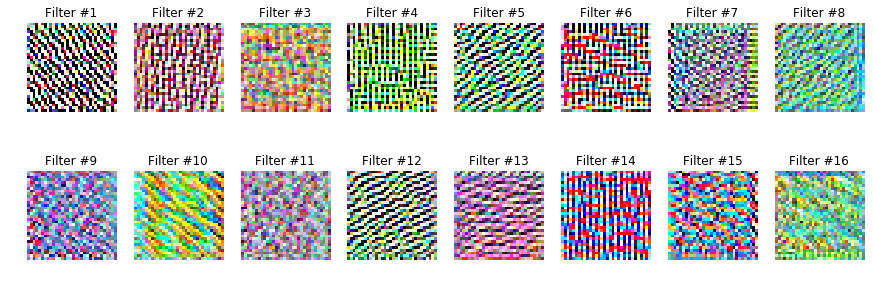

In [68]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

conv_activation_layers = []
for l1, l2 in pairwise(model.layers):
#     print(l1.__class__.__name__, l2.__class__.__name__)
    if isinstance(l1, Conv2D) and isinstance(l2, LeakyReLU):
        conv_activation_layers.append(l1)
#     for layer in model.layers:
#         if isinstance(layer, LeakyReLU):
#             print(layer)
#             prev_layer = layer.inbound_nodes[0].inbound_layers[0]
#             if isinstance(prev_layer, Conv2D):
#                 conv_activation_layers.append(layer)

for layer in conv_activation_layers:
    print(layer.name)
    plot_filters_stimuli(layer_name=layer.name, is_conv=True, model=model)

/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


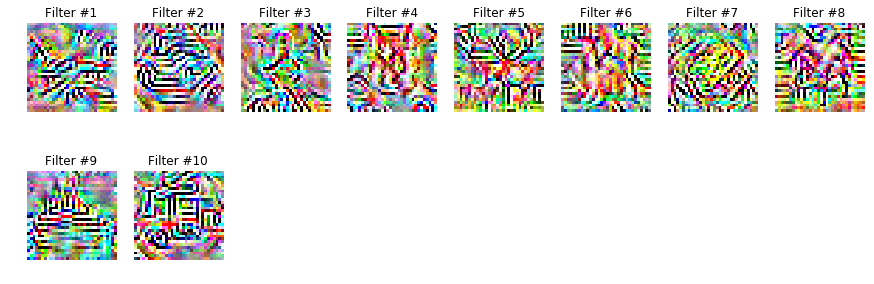

In [69]:
# maximum stimuli for last dense layer
last_dense_layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name, is_conv=False, 
                     iterations=200, step=0.1, model=model)

In [70]:
def maximum_stimuli_test_for_grader():
    layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
    output_index = 7
    stimuli, loss = find_maximum_stimuli(
        layer_name=layer.name, 
        is_conv=False, 
        filter_index=output_index,
        model=model,
        verbose=False
    )
    return model.predict_proba(stimuli[np.newaxis, :])[0, output_index]

In [71]:
maximum_stimuli_test_for_grader()

1.0

That's it! Congratulations!

What you've done:
- defined CNN architecture
- trained your model
- evaluated your model
- visualised learnt filters